## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [34]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [35]:
# Reading and loading the dataset
df = pd.read_csv("ab_data.csv")

# Showing first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [36]:
# Showing number of rows and columns
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [37]:
# Looking at unique values for each column
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [38]:
# Checking for tricky data types
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

d. The proportion of users converted.

In [39]:
# Find a number of users who converted and divide it by a total number of users
convertedUsersProp = df.query("converted == 1")["user_id"].count()/df.shape[0]
convertedUsersProp

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [40]:
# Count a number of mismatches where new_page is not equal to treatment
newPageAndTreatmentMismatch = df.query("(group != 'treatment' & landing_page == 'new_page') | (group == 'treatment' & landing_page != 'new_page')")["user_id"]
newPageAndTreatmentMismatch.count()

3893

f. Do any of the rows have missing values?

In [41]:
# Checking for null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [42]:
# Making a copy of the initial dataframe and assign it to variable df2
df2 = df.copy()

# Declaring generate_labels function that takes aggregated datagrame and return its labels (In the case below, Indexes)
def generate_labels(aggregated_dataframe):
    return aggregated_dataframe.index.tolist()

# Generating the indices of all the rows with the mismatch between treatment/control and new/old page
indicesToDrop = generate_labels(newPageAndTreatmentMismatch)

# Dropping all the rows with the mismatched values
df2.drop(indicesToDrop, inplace=True)

In [43]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [44]:
# Checking unique values in each column
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [45]:
# Find the duplicated rows
duplicateIds = df2[df2.duplicated(['user_id'], keep=False)]
duplicateIds

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [46]:
duplicateIds

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [47]:
# Removing the duplicate row based on user_id
df2.drop_duplicates(subset="user_id", inplace=True)
df2.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

In [48]:
# Double checking whether it was dropped
query = df2.query("user_id == 773192")
query

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [49]:
# Take a total number of converted users and divide it by a total users
conversionProb = df2.query("converted == 1")["user_id"].count() / df2.shape[0]
conversionProb

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [50]:
# Take all the users who were in the control group and converted and divide it by a number of users in the control group
conversionProbControl = df2.query("converted == 1 & group == 'control'")["user_id"].count() / df2.query("group == 'control'")["user_id"].count()
conversionProbControl

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [51]:
# Take all the users who were in a treatment group and converted and divide it by a number of users in a treatment group
conversionProbTreatment = df2.query("converted == 1 & group == 'treatment'")["user_id"].count() / df2.query("group == 'treatment'")["user_id"].count()
conversionProbTreatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [52]:
# Take a number of users who saw a new landing page and divide it by a total users
probNewpage = df2.query("landing_page == 'new_page'")["user_id"].count() / df2.shape[0]
probNewpage

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

### Conclusion
<ul>
    <li>The control (old) group converted better than the treatment(new) group by a small margin of 0.2%. </li> 
    <li>The probability of a user seeing a new page is around 0.5, which suggests that the difference in conversion is not caused by differences in users seeing more the new page rather than the old page </li>
</ul>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### <center> Null and Alternative Hypothesis: </center>
$$H_0: p_{new} - p_{old} \le 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [53]:
# We are assuming that both p_new and p_old have "true" success rates equal to converted succcess rate regardless of page
p_new = df2["converted"].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [54]:
# We are assuming that both p_new and p_old have "true" success rates equal to converted succcess rate regardless of page
p_old = df2["converted"].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [55]:
# Find a number of users in an experiment(treatment) group
n_new = df2.query("group == 'treatment'")["user_id"].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [56]:
# Find a number of users in a control group
n_old = df2.query("group == 'control'")["user_id"].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [57]:
# Draw n (n_new) samples from a binomial distribution using the null conversion rate (p_new)
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17608

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [58]:
# Draw n (n_old) samples from a binomial distribution using the null conversion rate (p_old)
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17566

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [59]:
# Find a mean of the simulated conversion rate in the treatment group
p_new = new_page_converted / n_new

# Find a mean of the simulated conversion rate in the control group
p_old = old_page_converted / n_old

# Observe the difference between the mean conversion between new(treatment) and old(control) group
p_new - p_old

0.0002590806679062807

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [60]:
p_diffs = []

# Do the same thing above (Simulation) but 10,000x and save the differences to p_diffs
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    #p_new = new_page_converted / n_new
    #p_old = old_page_converted / n_old
    diffs = (new_page_converted / n_new) - (old_page_converted / n_old)
    p_diffs.append(diffs) 

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   9.,   93.,  456., 1581., 2758., 2840., 1639.,  508.,  101.,
          15.]),
 array([-0.00442793, -0.00349603, -0.00256412, -0.00163222, -0.00070032,
         0.00023158,  0.00116348,  0.00209538,  0.00302729,  0.00395919,
         0.00489109]),
 <a list of 10 Patch objects>)

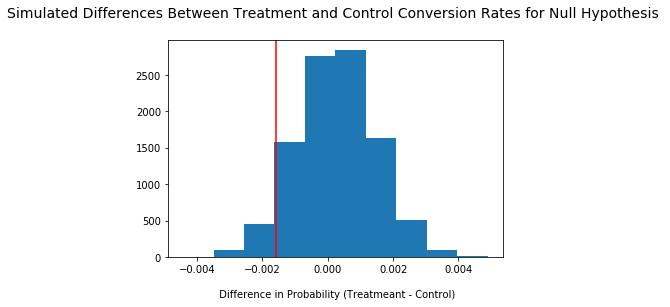

In [61]:
p_diffs = np.array(p_diffs)
obs_diff = conversionProbTreatment - conversionProbControl
plt.title("Simulated Differences Between Treatment and Control Conversion Rates for Null Hypothesis \n", fontsize=14)
plt.xlabel("\n Difference in Probability (Treatmeant - Control)")
plt.axvline(obs_diff, color='r');
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [64]:
(p_diffs > obs_diff).mean()

0.9384

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

### The p value is 0.9384. That is quite large if we compare it to the 0.05 (Alpha level) cutoff. Therefore, we fail to reject the null hypothesis, which means that there is not a sufficient evidence that there is an actual difference between the treatment (new page) and control group (old page).

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [65]:
# Importing statsmodel package
import statsmodels.api as sm

# Generating a number of converted users in the control group
convert_old = df2.query("group == 'control' & converted == 1")["user_id"].count()
# Generating a number of converted users in the treatment group
convert_new = df2.query("group == 'treatment' & converted == 1")["user_id"].count()
# Generating number of users who were exposed to the old page (control grouo)
n_old = df2.query("landing_page == 'old_page'")["user_id"].count()
# Generating number of users who were exposed to the new page (experiment group)
n_new = df2.query("landing_page == 'new_page'")["user_id"].count()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [69]:
# Assigning variables we generated in the previous cell and running the ztest
counts = np.array([convert_new, convert_old]) 
nobs = np.array([n_new, n_old])
stat, pval = sm.stats.proportions_ztest(counts, nobs, alternative="larger")
print(stat, pval)

-1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

### Since the p-value is still way larger than alpha (0.05) these findings are consistent with our results above. We fail to reject the null hypothesis as there is no sufficient evidence that there is an actual difference between the treatment (new page) and control group (old page). 

### If we take a look at the z-table (http://www.z-table.com/), under 95% confidence interval, for us to accept the null hypothesis, the z score should be between -1.96 and 1.96. As our z score -1.31 is between -1.96 and 1.96, we stay with the null.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since the response variable is categorical (Yes/No), the logistic regression would be a good match.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [88]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [32]:
# Creating an intercept column
df2["intercept"] = 1
# Creating dummy variables for the group column
df2[["control", "ab_page"]] = pd.get_dummies(df2["group"])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
# Running the logit model, predicting the conversion based on the group (ab_page)
lm = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Feb 2020   Pseudo R-squ.:               8.077e-06
Time:                        08:26:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

### The p-value associated with ab_page is 0.19, which is still above our alpha (0.05) level so the conclusion remains the same. We fail to reject the null hypothesis.

### The difference in p-values is caused by the type of test we conducted. In the part 2, we were using the one tailed test. The value now is different because it is a two tailed test.

#### <center> Part II: $$H_1: p_{new} > p_{old}$$ </center>
#### <center> Part III:$$H_1: p_{new} != p_{old}$$ </center>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

### It is good to consider other factors(variables) because additional variables can add predictive power to our models. The disadvantages are that you can bring an issue of multicollinearity where predictor variables can be correlated to one another. It can lead to coefficients being flipped from the direction we expect from regression.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
# Loading countries dataset and showing the first 5 rows
countries = pd.read_csv("countries.csv")
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [94]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,control
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [38]:
# Joining our df2 and countries datasets together based on user_id
df3 = df2.join(countries.set_index('user_id'), on='user_id')
# Checking for null values
df3.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
control         0
ab_page         0
country         0
dtype: int64

In [39]:
# Creating dummy variables for country column
df3[["US", "UK", "CA"]] = pd.get_dummies(df3["country"])

# Fitting the logistic model, predicting conversion based on the country of origin
lm = sm.Logit(df3["converted"], df3[["intercept", "US", "UK"]])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 15 Feb 2020   Pseudo R-squ.:               1.521e-05
Time:                        08:47:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
US            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

#### Conclusion
Once again, the p-values for each country are well above 0.05. Again, we fail to reject the null hypothesis and conclude that there is no significant contribution from country to differences in conversion rates for both pages

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
# Creating interaction variables for UK and US
df3["abpage_times_UK"] = df3["ab_page"] * df3["UK"]
df3["abpage_times_US"] = df3["ab_page"] * df3["US"]

In [41]:
# Running the Logit model with all the predictors
lm = sm.Logit(df3["converted"], df3[["intercept", "ab_page", "US", "UK", "abpage_times_UK", "abpage_times_US"]])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 Feb 2020   Pseudo R-squ.:               3.482e-05
Time:                        08:50:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page            -0.0206      0.014     -1.505      0.132      -0.047       0.006
US                 -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK                 -0.0057      0.019     -0.306      0.760      -0.043       0.031
abpage_times_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
abpage_times_US    -0.0469      0.054     -0.872      0.383      -0.152       0.059
===================================================================================
"""

### Conclusion
None of the variables have significant p-values. 
We will fail to reject the null and conclude that there is not sufficient evidence that would suggest that there is an interaction between country and page received that will predict whether a user converts or not.

Overall conclusion is that there is not a sufficient proof suggesting that the new page leads to a better conversion rate than the old page.

## Sources
<ol>
    <b> Logistic regression </b>
    <li>https://towardsdatascience.com/one-tailed-or-two-tailed-test-that-is-the-question-1283387f631c</li>
    <li>https://www.statsmodels.org/stable/index.html </li>
    
</ol>

<ol>
    <b> Data Cleaning </b>
    <li>https://medium.com/@purnasaigudikandula/exploratory-data-analysis-beginner-univariate-bivariate-and-multivariate-habberman-dataset-2365264b751</li> 
    <li>https://towardsdatascience.com/quick-dive-into-pandas-for-data-science-cc1c1a80d9c4</li>
    <li>https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf</li>
    <li>https://intellipaat.com/blog/tutorial/python-tutorial/numpy-cheat-sheet/</li>
<ol>
</ol>


<a id='conclusions'></a>
## Finishing Up


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])